In [1]:
from pathlib import Path
import yaml

import h5py
import Levenshtein
from multiprocessing import cpu_count
import numexpr
import numpy as np
from numpy.random import default_rng
import pandas as pd
from scipy.spatial.distance import cdist

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from scripts.general import analysis, data

tqdm.pandas(desc='Pandas op')
MAX_PROC = cpu_count() - 2
numexpr.set_num_threads(MAX_PROC)

_default_rc_params = plt.rcParams.copy()
plt.rcParams['font.size'] = 14


%load_ext autoreload
%autoreload 2

In [2]:
with open('experiment_config.yaml', 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)
    
seq_data = data.load_seq_and_abundance_data(config)[
    ['swissprot_ac', 'Median_molecules_per_cell']
]

In [3]:
def get_guides(experiment_config: dict, n=10) -> dict:
    seq_and_abundances = data.load_seq_and_abundance_data(experiment_config)
    seq_and_abundances = seq_and_abundances.sort_values('Median_molecules_per_cell').tail(n)
    return seq_and_abundances[['swissprot_ac', 'seq', 'Median_molecules_per_cell']].reset_index(drop=True)

## Mutations over shrinking guide set

In [4]:
from scripts import informed_mutation


model_eval = analysis.ModelEvaluator(config)
sequences = data.load_sequences_that_have_abundance(config)
guides = get_guides(config, n = 10)


seq_ordering = {}
with h5py.File(config['files']['saved_seq_orderings'], 'r') as store:
    for prot_id in store.keys():
        seq_ordering[prot_id] = np.array(store[prot_id], dtype=np.float32)


ordering_increase = informed_mutation.get_width_of_majority_ordering_range(seq_ordering)

rng = default_rng(seed=42)
sequence_entries = rng.choice(list(sequences.items()), size=100)


mutation_results = []
guide_selections = []

for i in tqdm(range(9), desc='Guide set'):
    higher_abundance_sequences = dict(guides[['swissprot_ac', 'seq']].values)
    guide_seq_orderings = {prot_id: seq_ordering[prot_id]
                           for prot_id in higher_abundance_sequences.keys()}
    
    for id_wt, seq_wt in sequence_entries:
        n_res_mut = informed_mutation.parse_num_res_spec('20%', seq_wt)
        pred_wt = model_eval.predict(seq_wt, inverse_boxcox=True)
        
        ## get_max_mutation_using_guides() ################
        mut_positions = np.argsort(seq_ordering[id_wt])[:n_res_mut]

        max_set_mut = ''
        max_pred_mut = -np.inf
        max_id_guide = ''
        for id_guide, ordering_guide in guide_seq_orderings.items():
            
            ## get_mutated_sequence() #############
            seq_mut = list(seq_wt)
            embedded_ordering_guide = ordering_guide.reshape(-1, 1)
            for mut_pos in mut_positions:
                # Avoid mutating leading M
                if mut_pos == 0:
                    mut_pos += 1
                dist_to_guide = cdist(
                    seq_ordering[id_wt][mut_pos].reshape(-1, 1) + ordering_increase,
                    embedded_ordering_guide
                )
                closest_idx = np.argmin(dist_to_guide)
                seq_mut[mut_pos] = list(sequences[id_guide])[closest_idx]
                
                guide_selections.append(
                    (id_guide, closest_idx, list(sequences[id_guide])[closest_idx])
                )
                
            seq_mut = ''.join(seq_mut)
            #######################################
            
            pred_mut = model_eval.predict(seq_mut, inverse_boxcox=True)
            if pred_mut > max_pred_mut:
                max_pred_mut = pred_mut
                max_set_mut = seq_mut
                max_id_guide = id_guide

        seq_mut, pred_mut = max_set_mut, max_pred_mut
        ####################################################
        
        mutation_results.append(
            (10 - i, id_wt, seq_wt, seq_mut, pred_wt, pred_mut, max_id_guide)
        )
    
    guides = guides.tail(guides.shape[0] - 1)
    
mutation_results_df = pd.DataFrame(
    mutation_results,
    columns=['n_guides', 'swissprot_ac', 'seq_wt', 'seq_mut', 'pred_wt', 'pred_mut', 'guide_id']
)

guide_selections_df = pd.DataFrame.from_records(
    guide_selections,
    columns=['guide_id', 'closest_idx', 'guide_AA']
)

[2022-04-01 16:41:34] [PID 30991] INFO:	modeling_utils.py:from_pretrained():166:	loading configuration file bert/learn_abundance_transformer_parallel_22-01-14-10-36-57_027418/config.json
[2022-04-01 16:41:34] [PID 30991] INFO:	modeling_utils.py:from_pretrained():183:	Model config {
  "attention_probs_dropout_prob": 0.0,
  "batch_size": 32,
  "finetuning_task": null,
  "gradient_accumulation_steps": 16,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "learning_rate": 2.5681310045153124e-07,
  "max_position_embeddings": 1024,
  "num_attention_heads": 4,
  "num_hidden_layers": 8,
  "num_labels": -1,
  "num_train_epochs": 500,
  "output_attentions": true,
  "output_hidden_states": false,
  "patience": 50,
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 30
}

[2022-04-01 16:41:34] [PID 30991] INFO:	modeling_utils.py:from_pretrained():514:	loading weights file b

In [5]:
def get_diffs(seq_wt:str, seq_mut:str):
    diffs = []
    for i in range(len(seq_wt)):
        if seq_wt[i] != seq_mut[i]:
            diffs.append((i + 1, seq_wt[i], seq_mut[i], len(seq_wt)))
    return pd.DataFrame.from_records(diffs, columns = ['pos', 'aa_wt', 'aa_mut', 'seq_len'])


substitutions = pd.concat(
    mutation_results_df
    .progress_apply(
        lambda row: get_diffs(row['seq_wt'], row['seq_mut']).assign(swissprot_ac = row['swissprot_ac'],
                                                                    n_guides = row['n_guides']),
        axis = 'columns'
    ).values,
    ignore_index=True
)

substitutions = substitutions.assign(pos_norm = substitutions['pos'] / substitutions['seq_len'])
substitutions = substitutions.assign(pos_bin = pd.qcut(substitutions['pos_norm'], q = 100, labels=range(1, 101)))

substitutions['pos'] = substitutions['pos'].astype('uint16')
substitutions['seq_len'] = substitutions['seq_len'].astype('uint16')
substitutions['pos_norm'] = substitutions['pos_norm'].astype('float32')
substitutions['pos_bin'] = substitutions['pos_bin'].astype('uint8')
substitutions['n_guides'] = substitutions['n_guides'].astype('uint8')

Pandas op: 100%|██████████| 900/900 [00:00<00:00, 1206.30it/s]


In [26]:
substitutions.head(2)

,pos,aa_wt,aa_mut,seq_len,swissprot_ac,n_guides,pos_norm,pos_bin
0,16,L,A,638,Q07442,10,0.025078,3
1,20,Q,A,638,Q07442,10,0.031348,3


Text(0.5, 0, 'N. guide sequences')

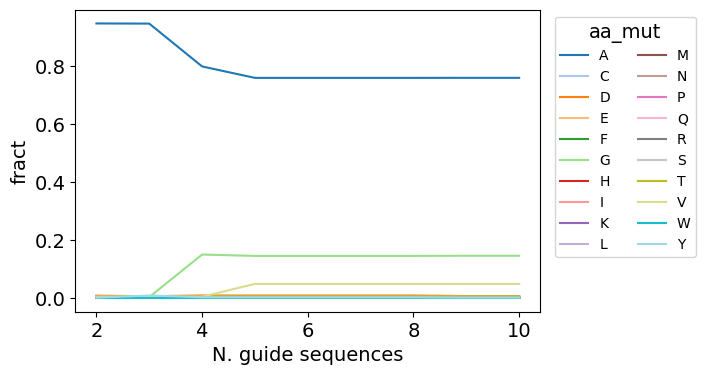

In [7]:
plt.figure(dpi=100, figsize=(6, 4))

replacement_counts = (
    substitutions
#     .query('pos_norm <= 0.2')
    .groupby(['n_guides', 'aa_mut'])['aa_wt'].count()
    .rename('count').reset_index()
)

replacement_counts = replacement_counts.groupby('n_guides').apply(
    lambda grp_df: grp_df.assign(fract = grp_df['count'] / grp_df['count'].sum())
)

g = sns.lineplot(
    data = replacement_counts,
    x = 'n_guides', y = 'fract',
    palette = 'tab20',
    hue = 'aa_mut'
)

sns.move_legend(g, 'upper right', bbox_to_anchor=(1.35, 1), fontsize = 10, ncol = 2)

plt.xlabel('N. guide sequences')

## Substitute choices

In [28]:
chosen_guide_ids = set(mutation_results_df['guide_id'].values)

guide_selections_df = guide_selections_df.assign(
    chosen = guide_selections_df['guide_id'].map(lambda prot_id: prot_id in chosen_guide_ids)
)

In [29]:
guide_selections_df.head(2)

,guide_id,closest_idx,guide_AA,chosen
0,P10592,310,L,False
1,P10592,613,G,False


In [42]:
guide_selections_count = (
    guide_selections_df
    .groupby(['chosen', 'guide_AA'])['guide_AA'].count()
    .rename('count').reset_index()
)

guide_selections_count = guide_selections_count.groupby('chosen').apply(
    lambda grp_df: grp_df.assign(fract = grp_df['count'] / grp_df['count'].sum())
)

<Figure size 1200x600 with 0 Axes>

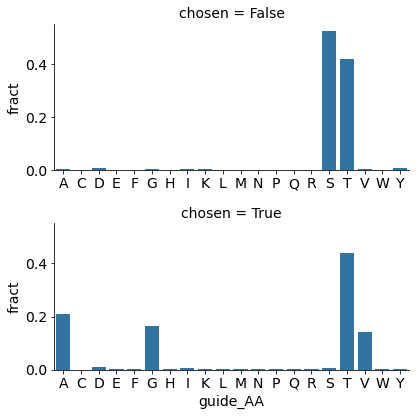

In [48]:
plt.figure(dpi = 100, figsize = (12, 6))

g = sns.FacetGrid(
    data = guide_selections_count, row = 'chosen',
    aspect = 2
)

g.map(
    sns.barplot, 
    'guide_AA', 'fract',
    order = sorted(set(guide_selections_count['guide_AA'].values))
)

for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
    g.tight_layout()